# In Depth A/B Testing - Lab

## Introduction

In this lab, you'll explore a survey from Kaggle regarding budding data scientists. With this, you'll form some initial hypotheses, and test them using the tools you've acquired to date. 

## Objectives

You will be able to:
* Conduct statistical tests on a real-world dataset

## Load the Dataset and Perform a Brief Exploration

The data is stored in a file called **multipleChoiceResponses_cleaned.csv**. Feel free to check out the original dataset referenced at the bottom of this lab, although this cleaned version will undoubtedly be easier to work with. Additionally, meta-data regarding the questions is stored in a file name **schema.csv**. Load in the data itself as a Pandas DataFrame, and take a moment to briefly get acquainted with it.

> Note: If you can't get the file to load properly, try changing the encoding format as in `encoding='latin1'`

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline
sns.set_style('darkgrid')

df = pd.read_csv('multipleChoiceResponses_cleaned.csv', encoding='latin1')

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compi

In [2]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26394 entries, 0 to 26393
Columns: 230 entries, GenderSelect to AdjustedCompensation
dtypes: float64(15), object(215)
memory usage: 46.3+ MB
None


,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity,exchangeRate,AdjustedCompensation
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Somewhat important,NaN,NaN,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,NaN,NaN
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,250000.0
4,Male,Taiwan,38.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Wages and Education

You've been asked to determine whether education is impactful to salary. Develop a hypothesis test to compare the salaries of those with Master's degrees to those with Bachelor's degrees. Are the two statistically different according to your results?

> Note: The relevant features are stored in the 'FormalEducation' and 'AdjustedCompensation' features.

### My hypotheses:

Null hypothesis: Education has no bearing on compensation

Alternative hypothesis: A Master's Degree produces at least a 5% increase in mean compensation above a Bachelor's Degree

In [3]:
df.FormalEducation.unique()

array(["Bachelor's degree", "Master's degree", 'Doctoral degree', nan,
       "Some college/university study without earning a bachelor's degree",
       'I did not complete any formal education past high school',
       'Professional degree', 'I prefer not to answer'], dtype=object)

In [4]:
def welch_t(a, b):
    """ Calculate Welch's t statistic for two samples. """
    numerator = a.mean() - b.mean()
    denominator = np.sqrt(a.var(ddof=1)/len(a) + b.var(ddof=1)/b.size)
    return abs(numerator/denominator)


def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    num = (a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)**2
    denom = ((a.var(ddof=1)**2) / (((a.size)**2) * (a.size-1))) + ((b.var(ddof=1)**2) / (((b.size)**2) * (b.size-1)))
    return num/denom

def p_value(a, b, two_sided=False):
    t = welch_t(a,b)
    df = welch_df(a,b)
    p = 1 - stats.t.cdf(t, df)
    if two_sided:
        p += p
    return p

In [5]:
#Subset the appropriate data into 2 groups
f1 = 'FormalEducation'
f2 = 'AdjustedCompensation'
f1c1 = "Master's degree"
f1c2 = "Bachelor's degree"

# the ~ essentially means 'not'...it produces the opposite output from what
# the rest of the argument would seem to return (e.g. ~True returns False)
subset = df[(~df[f1].isnull()) & (~df[f2].isnull())]
s1 = subset[subset[f1]==f1c1][f2]
s2 = subset[subset[f1]==f1c2][f2]

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


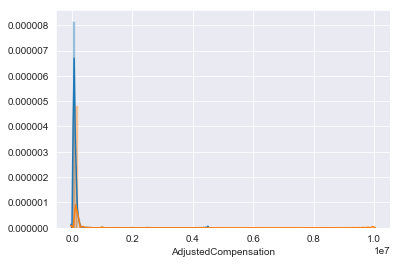

In [6]:
sns.distplot(s1)
sns.distplot(s2);

In [7]:
print('Comparison of {} for {} and {}'.format(f2, f1c1, f1c2))
print("Median Values: \ts1: {} \ts2: {}".format(round(s1.median(),2), round(s2.median(),2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(s1.mean(),2), round(s2.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(s1), len(s2)))
print("Welch's t-test p-value:", p_value(s1, s2))

Comparison of AdjustedCompensation for Master's degree and Bachelor's degree
Median Values: 	s1: 53812.17 	s2: 38399.4
Mean Values: 	s1: 69139.9 	s2: 64887.1
Sample sizes: 	s1: 1990 	s2: 1107
Welch's t-test p-value: 0.33077639451272445


#### Pretty awful. Let's remove compensation outliers.

In [8]:
#Investigate Percentiles
for q in np.linspace(.9, 1, num=11):
    s1q =  round(s1.quantile(q=q), 2)
    s2q =  round(s2.quantile(q=q), 2)
    print('{}th percentile:\tset1: {}\tset2: {}'.format(round(q,2), s1q, s2q))

0.9th percentile:	set1: 135000.0	set2: 120346.5
0.91th percentile:	set1: 140000.0	set2: 126460.0
0.92th percentile:	set1: 149640.0	set2: 132615.4
0.93th percentile:	set1: 150000.0	set2: 140000.0
0.94th percentile:	set1: 160000.0	set2: 143408.8
0.95th percentile:	set1: 166778.6	set2: 150000.0
0.96th percentile:	set1: 180000.0	set2: 179849.74
0.97th percentile:	set1: 200000.0	set2: 195000.0
0.98th percentile:	set1: 211100.0	set2: 200000.0
0.99th percentile:	set1: 250000.0	set2: 250000.0
1.0th percentile:	set1: 4498900.0	set2: 9999999.0


In [9]:
print('Repeated Test with Ouliers Removed:')
print('S1: {}\tS2: {}'.format(f1c1, f1c2))

# set outlier threshold to be double the 99th percentile for Master's degrees ($500,000)
outlier_threshold = 300000
s1 = subset[(subset[f1]==f1c1) & (subset[f2]<=outlier_threshold)][f2]
s2 = subset[(subset[f1]==f1c2) & (subset[f2]<=outlier_threshold)][f2]
print("Median Values: \ts1: {} \ts2: {}".format(round(s1.median(),2), round(s2.median(),2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(s1.mean(),2), round(s2.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(s1), len(s2)))
print("Welch's t-test p-value with outliers removed:", p_value(s1, s2))

Repeated Test with Ouliers Removed:
S1: Master's degree	S2: Bachelor's degree
Median Values: 	s1: 53248.45 	s2: 37488.0
Mean Values: 	s1: 63123.54 	s2: 51968.52
Sample sizes: 	s1: 1980 	s2: 1097
Welch's t-test p-value with outliers removed: 3.1432543234899413e-09


C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


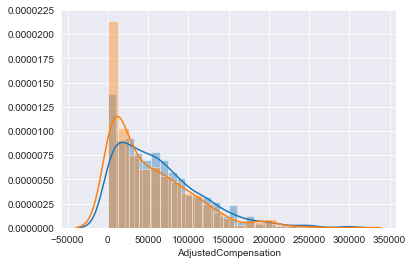

In [10]:
sns.distplot(s1)
sns.distplot(s2);

### Interpretation

With the p-value score well below 0.001%, it is almost certain that Master's Degree holders make more than people with only a Bachelor's Degree.

## Wages and Education II

Now perform a similar statistical test comparing the AdjustedCompensation of those with Bachelor's degrees and those with Doctorates. If you haven't already, be sure to explore the distribution of the AdjustedCompensation feature for any anomalies. 

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


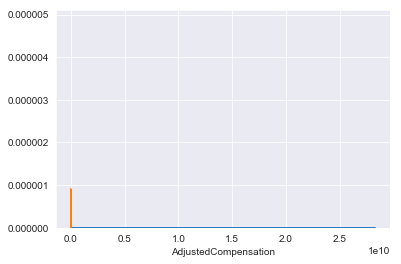

In [11]:
#Subset the appropriate data into 2 groups
f1 = 'FormalEducation'
f2 = 'AdjustedCompensation'
f1c1 = 'Doctoral degree'
f1c2 = "Bachelor's degree"

# the ~ essentially means 'not'...it produces the opposite output from what
# the rest of the argument would seem to return (e.g. ~True returns False)
subset = df[(~df[f1].isnull()) & (~df[f2].isnull())]
s1 = subset[subset[f1]==f1c1][f2]
s2 = subset[subset[f1]==f1c2][f2]

sns.distplot(s1)
sns.distplot(s2);

In [12]:
print('Comparison of {} for {} and {}'.format(f2, f1c1, f1c2))
print("Median Values: \ts1: {} \ts2: {}".format(round(s1.median(),2), round(s2.median(),2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(s1.mean(),2), round(s2.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(s1), len(s2)))
print("Welch's t-test p-value:", p_value(s1, s2))

Comparison of AdjustedCompensation for Doctoral degree and Bachelor's degree
Median Values: 	s1: 74131.92 	s2: 38399.4
Mean Values: 	s1: 29566175.76 	s2: 64887.1
Sample sizes: 	s1: 967 	s2: 1107
Welch's t-test p-value: 0.15682381994720251


In [13]:
#Investigate Percentiles
for q in np.linspace(.95, 1, num=6):
    s1q =  round(s1.quantile(q=q), 2)
    s2q =  round(s2.quantile(q=q), 2)
    print('{}th percentile:\tset1: {}\tset2: {}'.format(round(q,2), s1q, s2q))

0.95th percentile:	set1: 200000.0	set2: 150000.0
0.96th percentile:	set1: 220999.61	set2: 179849.74
0.97th percentile:	set1: 240879.14	set2: 195000.0
0.98th percentile:	set1: 277349.78	set2: 200000.0
0.99th percentile:	set1: 336800.0	set2: 250000.0
1.0th percentile:	set1: 28297400000.0	set2: 9999999.0


In [14]:
print('Repeated Test with Ouliers Removed:')
print('S1: {}\tS2: {}'.format(f1c1, f1c2))

# set outlier threshold to be double the 99th percentile for Master's degrees ($500,000)
outlier_threshold = 250000
s1 = subset[(subset[f1]==f1c1) & (subset[f2]<=outlier_threshold) & (subset[f2]!=0)][f2]
s2 = subset[(subset[f1]==f1c2) & (subset[f2]<=outlier_threshold) & (subset[f2]!=0)][f2]
print("Median Values: \ts1: {} \ts2: {}".format(round(s1.median(),2), round(s2.median(),2)))
print("Mean Values: \ts1: {} \ts2: {}".format(round(s1.mean(),2), round(s2.mean(),2)))
print('Sample sizes: \ts1: {} \ts2: {}'.format(len(s1), len(s2)))
print("Welch's t-test p-value with outliers removed:", p_value(s1, s2))

Repeated Test with Ouliers Removed:
S1: Doctoral degree	S2: Bachelor's degree
Median Values: 	s1: 71749.56 	s2: 38345.78
Mean Values: 	s1: 81437.82 	s2: 52122.67
Sample sizes: 	s1: 939 	s2: 1088
Welch's t-test p-value with outliers removed: 0.0


C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


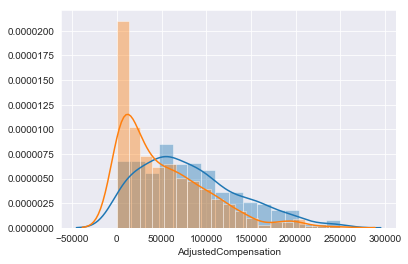

In [15]:
sns.distplot(s1)
sns.distplot(s2);

## Wages and Education III

Remember the multiple comparisons problem; rather than continuing on like this, perform an ANOVA test between the various 'FormalEducation' categories and their relation to 'AdjustedCompensation'.

In [16]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df         F    PR(>F)
C(FormalEducation)  6.540294e+17     6.0  0.590714  0.738044
Residual            7.999414e+20  4335.0       NaN       NaN


In [17]:
formula = '{} ~ C({})'.format(f2, f1)
lm = ols(formula, df[df[f2]<=3*10**5]).fit()   #here I plug in an argument to filter out outliers
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df          F        PR(>F)
C(FormalEducation)  5.306853e+11     6.0  30.558557  4.061426e-36
Residual            1.244287e+13  4299.0        NaN           NaN


## Additional Resources

Here's the original source where the data was taken from:  
    [Kaggle Machine Learning & Data Science Survey 2017](https://www.kaggle.com/kaggle/kaggle-survey-2017)

## Summary

In this lab, you practiced conducting actual hypothesis tests on actual data. From this, you saw how dependent results can be on the initial problem formulation, including preprocessing!